In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("gdrive/MyDrive/Phase_Retrieval/Código/utils")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.layers import Layer
from Generador import get_generador
from LoadData import *
from AcquisitionLayer import *
from InitializationLayer import *
from InitializationUnrolled import *
from CallBacks import *
#from pruebas_layers import *
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
BATCH_SIZE = 32
dim=(32,32)
DATASET_DIR = "../DATASET"
TRAIN_DIR = os.path.join(DATASET_DIR, "TRAIN")
TEST_DIR = os.path.join(DATASET_DIR, "TEST")
VALIDATION_DIR = os.path.join(DATASET_DIR, "VALIDATION")
RESULTS_DIR = "../results"



train_generator = DataGenerator(TRAIN_DIR, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
test_generator = DataGenerator(TEST_DIR, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
validation_generator = DataGenerator(VALIDATION_DIR, batch_size=BATCH_SIZE, dim=dim, shuffle=False)

X = test_generator.__getitem__(2)[0]

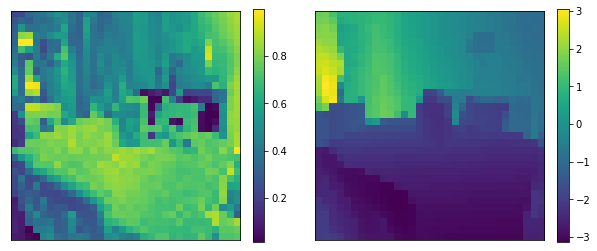

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

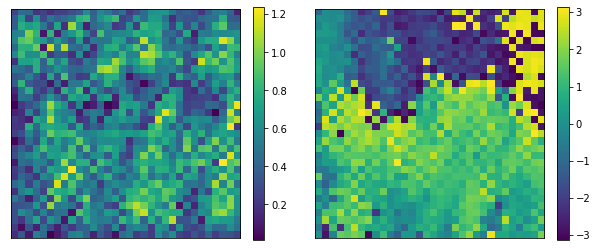

In [ ]:
conv_psf, D = Muestreo(1)(X)
inicializacion = LearneableInit(100)([conv_psf, D])
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(inicializacion[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(inicializacion[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

(32, 32, 32, 1)


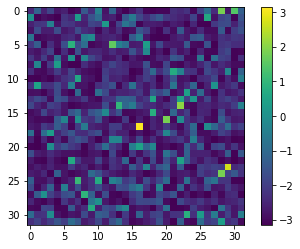

In [ ]:
print(conv_psf.shape)
#fig, axs = plt.subplots(1,1,figsize=(10,10))
plt.imshow(conv_psf[0,:,:,0]);
plt.colorbar(a,fraction=0.046)
plt.show()

In [ ]:
def get_model(n_power = 50, gene = False, unrolled = False, input_size=(*dim, 2), L = 1, batch_size = BATCH_SIZE):
  trueImg = tf.keras.Input(shape=input_size, batch_size=batch_size, name='inputs')
  muestras, codigo = Muestreo(L)(trueImg)

  if (unrolled):
    inicializacion = InitializationUnrolled(n_power)([muestras, codigo])
  else:
    inicializacion = LearneableInit(n_power)([muestras, codigo])
  if (gene):
    salida = get_generador(inicializacion)
    model = tf.keras.Model(inputs=trueImg, outputs=salida)
  else:
    model = tf.keras.Model(inputs=trueImg, outputs=inicializacion)
  return model

In [ ]:
def run_train(n_epochs, unrolled, results_dir = RESULTS_DIR, train_g = None, test_g = None):
  if (unrolled):
    type_model = "unrolled"
  else:
    type_model = "basic"

  chekpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(results_dir, type_model+"_last_weights.h5"), save_weights_only=True)
  save_results = SaveResults_CB(results_dir, generator = test_g, type_model=type_model)

  opti = tf.keras.optimizers.Adam()
  model = get_model(n_power=100, gene = True, unrolled=unrolled)
  model.save_weights(os.path.join(results_dir, type_model+"_initial_weights.h5"))


  model.compile(optimizer=opti, loss=tf.keras.losses.MeanSquaredError())
  history = model.fit(train_g, epochs=n_epochs, batch_size=BATCH_SIZE,validation_data=test_g, callbacks=[chekpoint, save_results])
  return model, history


In [ ]:
# TRAIN BASIC MODEL
model, history = run_train(2, unrolled=False, results_dir = RESULTS_DIR, train_g = test_generator, test_g = test_generator)

Epoch 1/2
4/4 [==============================] - 26s 2s/step - loss: 2.6288 - val_loss: 1.7774
Epoch 2/2
4/4 [==============================] - 3s 786ms/step - loss: 1.7594 - val_loss: 1.7745


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

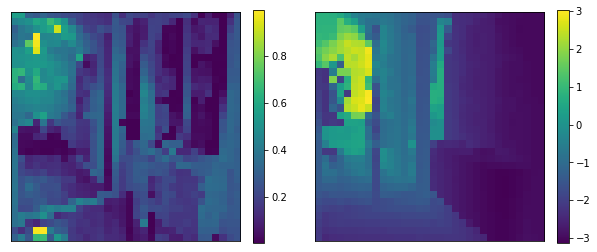

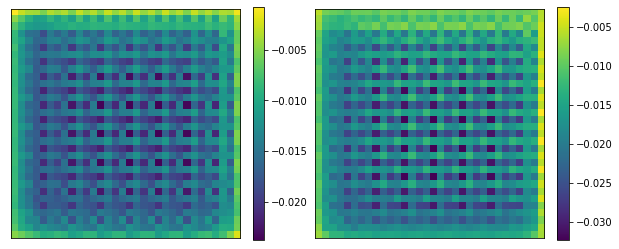

In [ ]:
X_Test = validation_generator.get_random_image()

fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_Test[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_Test[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

X_Test = np.repeat(X_Test, 32, 0)
X_pred = model.predict(X_Test)
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_pred[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_pred[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

In [ ]:
# TRAIN UNROLLED MODEL
model, history = run_train(2, unrolled=True, results_dir = RESULTS_DIR, train_g = test_generator, test_g = test_generator)

Epoch 1/2
4/4 [==============================] - 28s 2s/step - loss: 2.0147 - val_loss: 1.7781
Epoch 2/2
4/4 [==============================] - 3s 749ms/step - loss: 1.6984 - val_loss: 1.7592


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

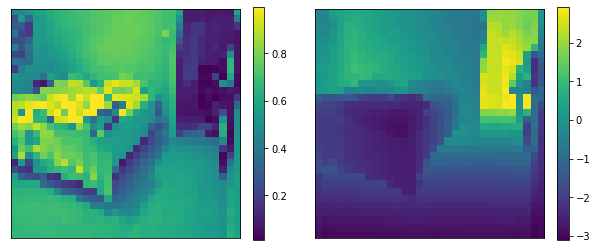

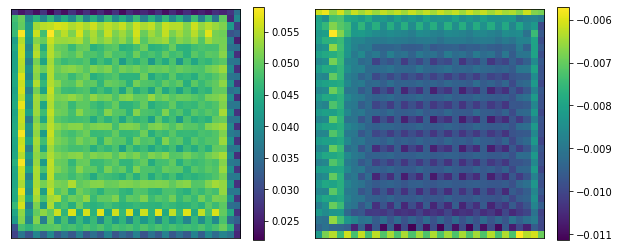

In [ ]:
X_Test = validation_generator.get_random_image()

fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_Test[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_Test[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

X_Test = np.repeat(X_Test, 32, 0)
X_pred = model.predict(X_Test)
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_pred[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_pred[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

In [ ]:
X_Test = validation_generator.get_random_image()
X_Test = np.repeat(X_Test, 32, 0)

In [ ]:
model_basic = get_model(n_power=100, gene = True, unrolled=False)

In [ ]:
model_basic.load_weights(os.path.join(RESULTS_DIR, "basic_last_weights.h5"))

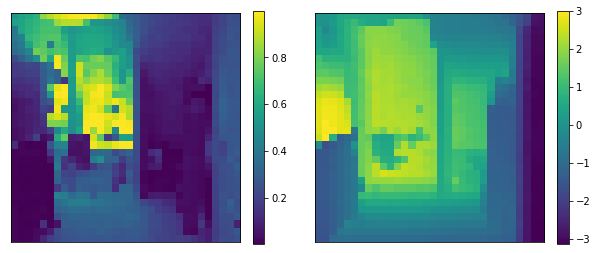

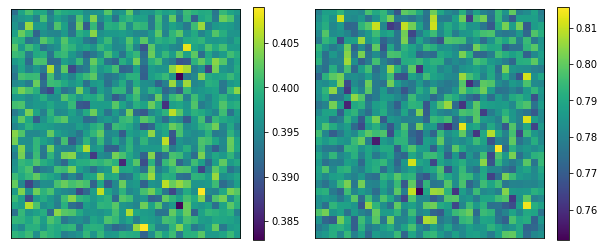

In [ ]:
initialization_basic = tf.keras.Model(model_basic.input, model_basic.layers[2].output)


fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_Test[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_Test[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

X_Test = np.repeat(X_Test, 32, 0)
X_pred = initialization_basic.predict(X_Test)
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_pred[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_pred[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

In [ ]:
model_unrolled = get_model(n_power=100, gene = True, unrolled=True)

In [ ]:
model_unrolled.load_weights(os.path.join(RESULTS_DIR, "unrolled_last_weights.h5"))

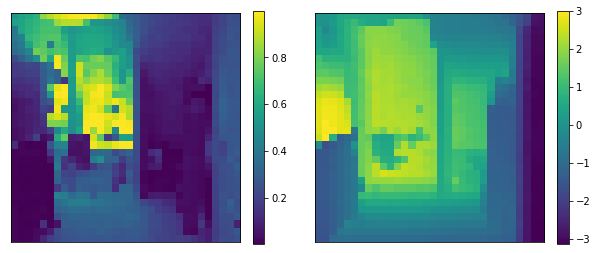

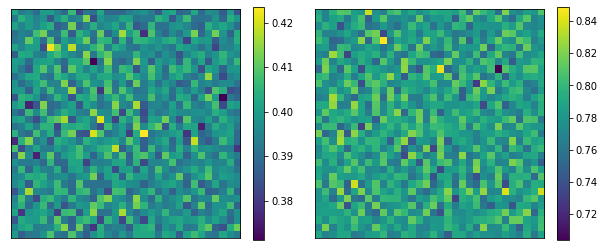

In [ ]:
initialization_unrolled = tf.keras.Model(model_unrolled.input, model_unrolled.layers[2].output)

fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_Test[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_Test[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()


X_pred = initialization_unrolled.predict(X_Test)
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_pred[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_pred[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()